## Summary
#### This notebook implements the [wavenet paper](https://arxiv.org/abs/1609.03499) from deep mind.
#### Fix BatchNorm for new arch to support for tensors with >2 dims
#### Rest of the notebook is same as that in makemore part 3

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# read all the words
words = open("../names.txt", 'r').read().split('\n')
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
# Build an vocabulary of characters and mapping to/from integers
vocab = ['.'] + sorted(list(set(''.join(words))))
stoi = {k: v for k,v in zip(vocab, range(len(vocab)))}
print(stoi)
itos = {v: k for k,v in stoi.items()}
print(itos)
vocab_size = len(itos)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [93]:
# Build the dataset
block_size = 8 # context length: How many characters do we need to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in list(w) + ['.']:
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            context = context + [idx]
            context = context[1:]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])      # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])      # 10%

print(f"Train dataset size: {Xtr.shape}, {Ytr.shape}")
print(f"Dev dataset size: {Xdev.shape}, {Ydev.shape}")
print(f"Test dataset size: {Xte.shape}, {Yte.shape}")

Train dataset size: torch.Size([182625, 8]), torch.Size([182625])
Dev dataset size: torch.Size([22655, 8]), torch.Size([22655])
Test dataset size: torch.Size([22866, 8]), torch.Size([22866])


In [95]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join([itos[i.item()] for i in x]), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


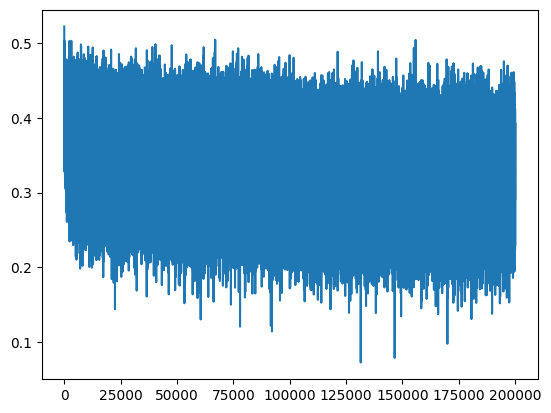

In [35]:
# Plot of raw loss values
plt.plot(range(len(lossvals)), lossvals);

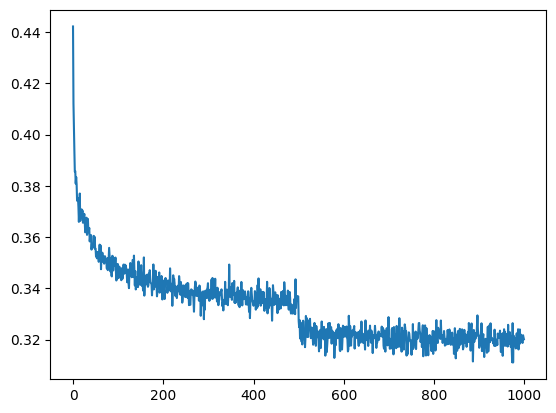

In [9]:
# Smoothened loss values - non overlapping windows
plt.plot(range(1000), torch.tensor(lossvals).view(1000, -1).mean(1))

## Summary + Pytorchyfying the code

In [117]:
class Linear():
    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])

class BatchNorm1d():
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.Training = True
        self.momentum = momentum
        # Batch norm params (trainable)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # batch norm running mean and var: buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.Training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim=dim, keepdim=True)
            xvar = x.var(dim=dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.Training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1 - self.momentum) + xmean * self.momentum
                self.running_var = self.running_var * (1 - self.momentum) + xvar * self.momentum
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh():
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding():
    
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, ix):
        self.out = self.weight[ix]
        return self.out
    
    def parameters(self):
        return [self.weight]
        

class Flatten():
    
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

class FlattenConsecutive():
    
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B,T,C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(dim=1)
        self.out = x
        return self.out

    def parameters(self):
        return []
    
class Sequential():
    
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [118]:
torch.manual_seed(412) # seed rng for reproducibility

In [119]:
n_embd = 10
n_hidden = 68
C = torch.randn((vocab_size, n_embd))

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    #Linear(n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
    #Linear(n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
    #Linear(n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=True), #BatchNorm1d(vocab_size),
    
])

with torch.no_grad():
    # make last layer less confident 
    layers[-1].gamma *= 0.1 # when the last layer is BatchNorm
    #layers[-1].weights *= 0.1  # When last layer is Linear
    # all other layers: apply gain
    for layer in layers:
        if isinstance(layer, Linear):
            layer.weights *= 1.0 #5/3.0

parameters = model.parameters()
print(f"Total parameters: {sum([p.nelement() for p in parameters])}")
for p in parameters:
    p.requires_grad = True

Total parameters: 22397


In [120]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
print(Xb)

torch.Size([4, 8])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0, 11,  1,  3,  5, 12, 25],
        [ 0,  0,  0,  0,  0,  0,  0, 18],
        [ 0,  0,  0,  0,  0,  0, 12,  1]])


In [121]:
for layer in model.layers:
    print(layer.__class__.__name__, tuple(layer.out.shape))

Embedding (4, 8, 10)
FlattenConsecutive (4, 4, 20)
Linear (4, 4, 68)
BatchNorm1d (4, 4, 68)
Tanh (4, 4, 68)
FlattenConsecutive (4, 2, 136)
Linear (4, 2, 68)
BatchNorm1d (4, 2, 68)
Tanh (4, 2, 68)
FlattenConsecutive (4, 136)
Linear (4, 68)
BatchNorm1d (4, 68)
Tanh (4, 68)
Linear (4, 27)


In [122]:
# Run the optimization
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # Update to data ratio for the parameters of the network

for i in range(max_steps):
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, yb)
    
    # backward pass
    for layer in model.layers:
        layer.out.retain_grad()  # DEBUG purpose. to visualize the gradients
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= p.grad * lr
    
    # Track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item(): .4f}")
    lossi.append(loss.log10().item())
    ud.append([((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    #if i > 1000:
    #    break # for debugging

      0/ 200000:  3.4155
  10000/ 200000:  1.9134
  20000/ 200000:  1.9758
  30000/ 200000:  1.5796
  40000/ 200000:  2.3309
  50000/ 200000:  1.9923
  60000/ 200000:  2.3753
  70000/ 200000:  2.0919
  80000/ 200000:  2.1630
  90000/ 200000:  2.0974
 100000/ 200000:  1.9084
 110000/ 200000:  2.0429
 120000/ 200000:  1.7633
 130000/ 200000:  2.0827
 140000/ 200000:  2.2100
 150000/ 200000:  1.8722
 160000/ 200000:  1.7974
 170000/ 200000:  1.8981
 180000/ 200000:  1.7799
 190000/ 200000:  1.7348


layer 4 (      Tanh): mean +0.01, std 0.59, saturated: 17.28%
layer 8 (      Tanh): mean +0.01, std 0.70, saturated: 21.09%
layer 12 (      Tanh): mean -0.01, std 0.79, saturated: 18.29%


Text(0.5, 1.0, 'activation distribution')

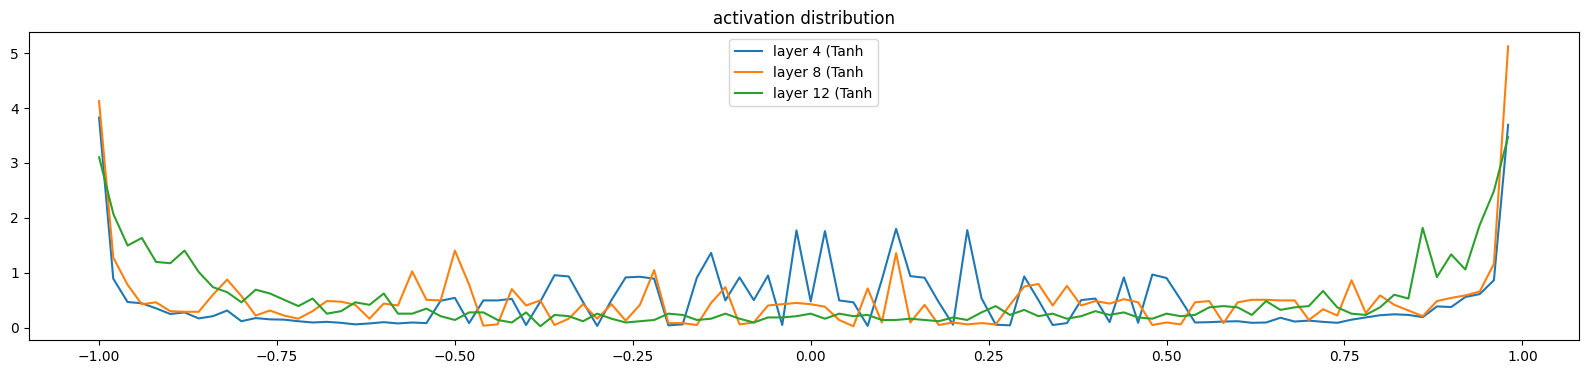

In [123]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model.layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 3 (      Tanh): mean +0.000000, std 7.450419e-03
layer 6 (      Tanh): mean -0.000000, std 5.578246e-03


Text(0.5, 1.0, 'gradient distribution')

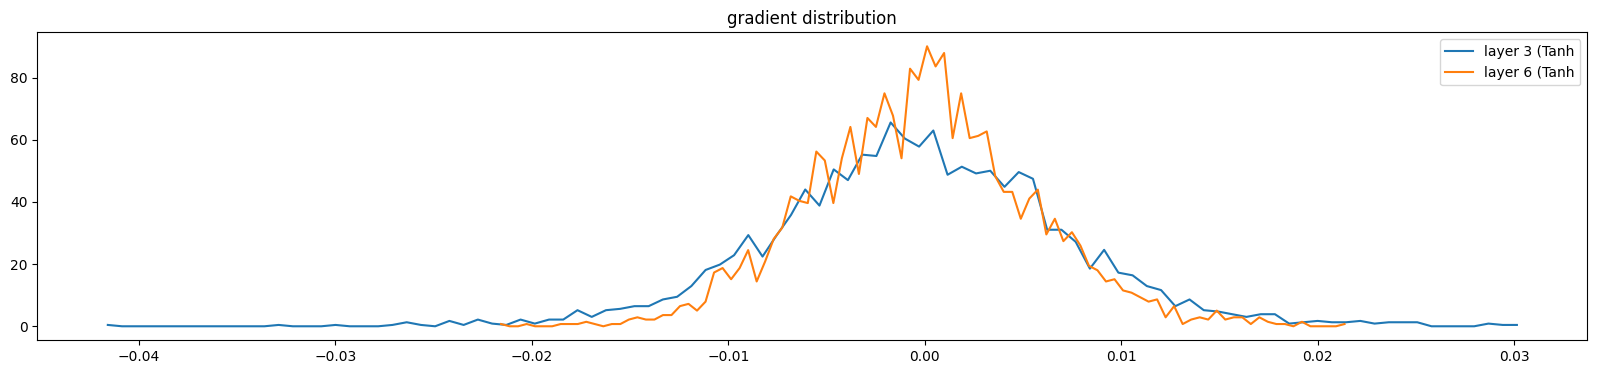

In [83]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model.layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000817 | std 2.032276e-02 | grad:data ratio 1.536499e-02
weight  (30, 100) | mean +0.000235 | std 1.522133e-02 | grad:data ratio 3.245579e-02
weight (100, 100) | mean +0.000057 | std 1.055496e-02 | grad:data ratio 4.110704e-02
weight  (100, 27) | mean -0.000077 | std 1.124636e-02 | grad:data ratio 3.199185e-02


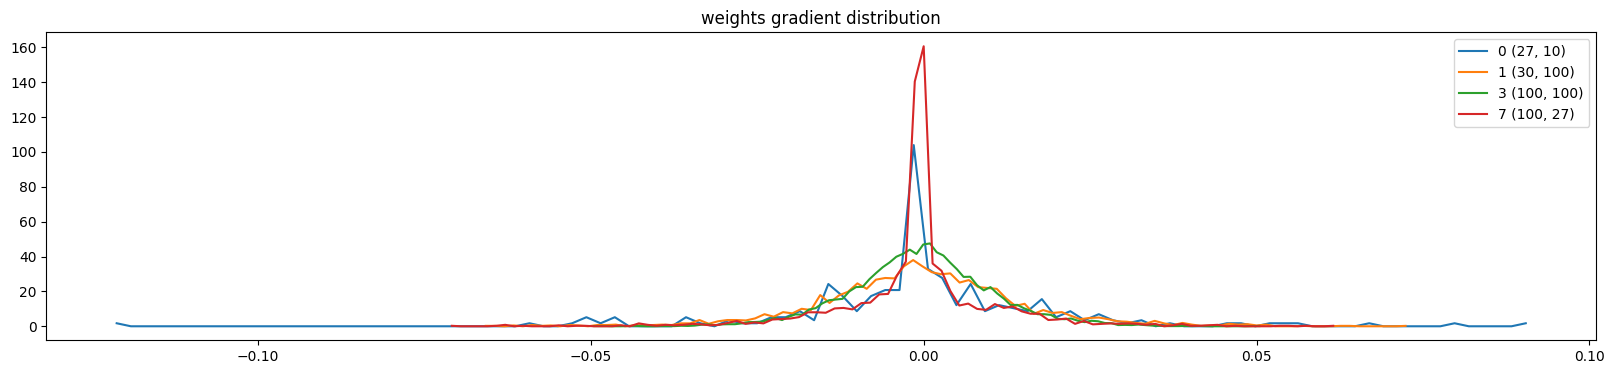

In [84]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

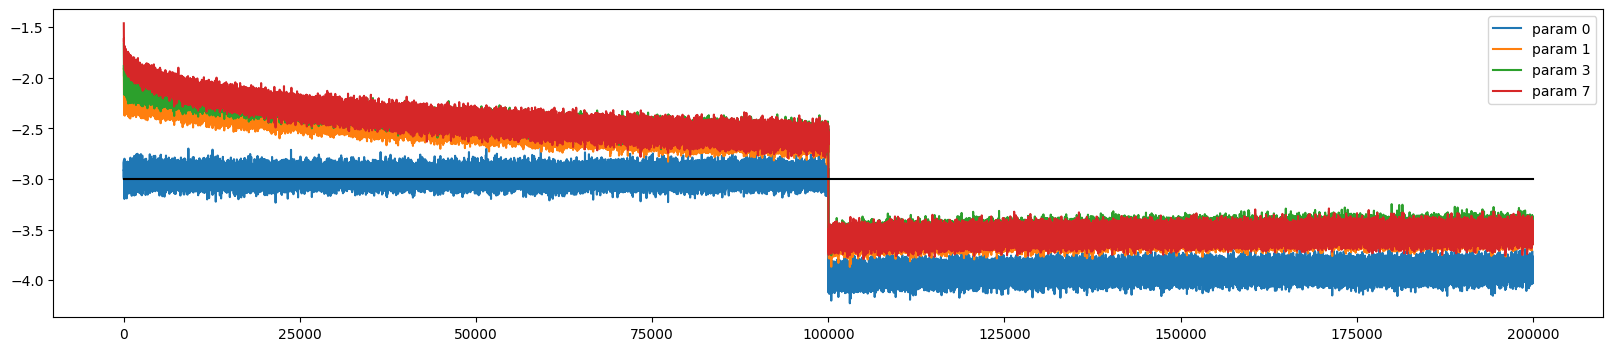

In [85]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [86]:
@torch.no_grad() # This decorator disables gradient tracking
def split_loss(split):
    X, Y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    print(f'{split}, loss={loss.item()}')
    return loss.item()

# Put layers into eval mode
for layer in model.layers:
    layer.Training = False
split_loss('train')
split_loss('val')

train, loss=2.04066801071167
val, loss=2.1023335456848145


2.1023335456848145

In [87]:
# sample from the model
g = torch.Generator().manual_seed(214748364 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word
    #break

nathafidhidy.
codora.
rayloreezarashtynn.
marcie.
gabritaalian.
heen.
gracefs.
kmourda.
naoa.
izyannano.
ansi.
ane.
liyah.
jose.
shanar.
jaizlea.
faifa.
skylar.
mariellewayny.
kalia.


In [88]:
# DONE; BONUS content below, not covered in video

In [89]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
  
    g = torch.Generator().manual_seed(2147483647+1)
    x = torch.randn(5, generator=g) * 5
    x[0] = x0 # override the 0th example with the slider
    mu = x.mean()
    sig = x.std()
    y = (x - mu)/sig

    plt.figure(figsize=(10, 5))
    # plot 0
    plt.plot([-6,6], [0,0], 'k')
    # plot the mean and std
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
    # plot little lines connecting input and output
    for i in range(len(x)):
        plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
    # plot the input and output values
    plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
    plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
    plt.xlim(-6, 6)
    # title
    plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));

interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [90]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [91]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559
